<a href="https://colab.research.google.com/github/DheerajNair/Covid-19-Sentiment-Analysis-using-fastText/blob/main/Sentiment_analysis_using_fastText%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Setup

In [1]:
import torch
import pandas as pd


import os
import io
import codecs
import joblib
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import tensorflow as tf

from datetime import datetime
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D


import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#load data
df = pd.read_csv('/content/drive/MyDrive/finalSentimentdata2.csv')

In [3]:
#preview
df.head()

,Unnamed: 0,sentiment,text
0,3204,sad,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...
1,1431,joy,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …
2,654,joy,will nature conservation remain a priority in post corona bangladesh | the daily star
3,2530,sad,"coronavirus disappearing in italy show this to ""intellectuals"" who say lockdowns do not work …"
4,2296,sad,uk records lowest daily virus death toll since start of lockdown govt


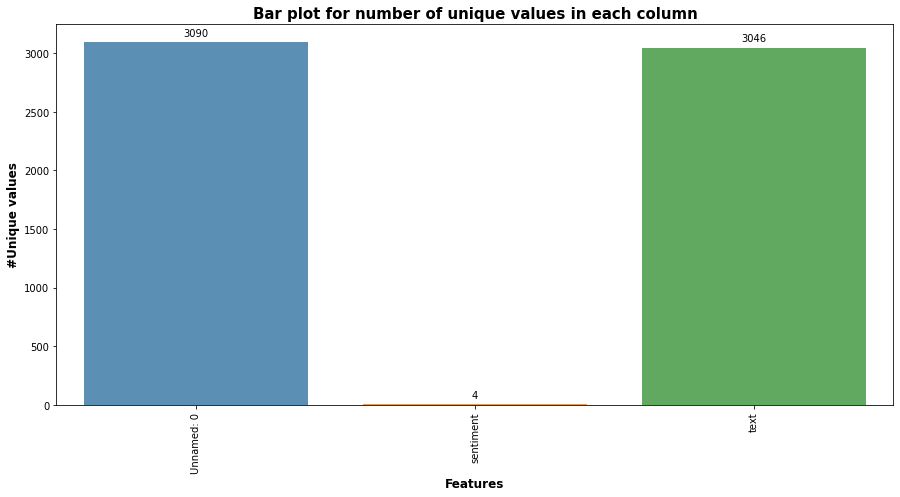

In [4]:
#Unique Values In Each Feature Coulmn

unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

# Feature Set Generation

In [5]:
#Number of characters 
def count_chars(text):
    return len(text)
    print(text)

df['char_count'] = df["text"].apply(lambda x:count_chars(x))


In [6]:
  df['char_count']

0       270
1        93
2        85
3        94
4        69
       ... 
3085    243
3086    101
3087     66
3088    277
3089    100
Name: char_count, Length: 3090, dtype: int64

In [7]:
#Number of words
def count_words(text):
    return len(text.split())

df['word_count'] = df["text"].apply(lambda x:count_words(x))

In [8]:
df['word_count']

0       50
1       20
2       14
3       15
4       12
        ..
3085    46
3086    20
3087    10
3088    51
3089    19
Name: word_count, Length: 3090, dtype: int64

In [9]:
#Number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

df['capital_char_count'] = df["text"].apply(lambda x:count_capital_chars(x))

In [10]:
#Number of capital words
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

df['capital_word_count'] = df["text"].apply(lambda x:count_capital_words(x))

In [11]:
#Count the number of punctuations
def count_punctuations(text):
    punctuations='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

df['punct_count'] = df["text"].apply(lambda x:count_punctuations(x))

In [12]:
#Number of words in quotes
def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

df['quoted_word_count'] = df["text"].apply(lambda x:count_words_in_quotes(x))

In [13]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
#Number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

df['sent_count'] = df["text"].apply(lambda x:count_sent(x))

In [15]:
#Count the number of unique words
def count_unique_words(text):
    return len(set(text.split()))

df['unique_word_count'] = df["text"].apply(lambda x:count_unique_words(x))

In [16]:
#Count of hashtags
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

df['htag_count'] = df["text"].apply(lambda x:count_htags(x))

In [17]:
#Count of mentions
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

df['mention_count'] = df["text"].apply(lambda x:count_mentions(x))

In [18]:
#Count of stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

df['stopword_count'] = df["text"].apply(lambda x:count_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
#Calculating average word length

df['avg_wordlength'] = df['char_count']/df['word_count']

In [20]:
#Calculating average sentence length

df['avg_sentlength'] = df['word_count']/df['sent_count']

In [21]:
#Unique words vs word count feature

df['unique_vs_words'] = df['unique_word_count']/df['word_count']

In [22]:
#Stopwords count vs words counts feature

df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [23]:
df.columns

Index(['Unnamed: 0', 'sentiment', 'text', 'char_count', 'word_count',
       'capital_char_count', 'capital_word_count', 'punct_count',
       'quoted_word_count', 'sent_count', 'unique_word_count', 'htag_count',
       'mention_count', 'stopword_count', 'avg_wordlength', 'avg_sentlength',
       'unique_vs_words', 'stopwords_vs_words'],
      dtype='object')

In [24]:
df['sentiment'].value_counts()

fear     801
sad      795
anger    767
joy      727
Name: sentiment, dtype: int64

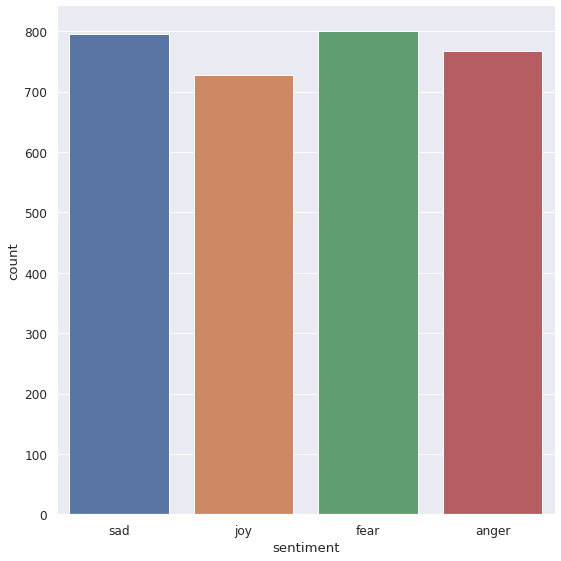

In [25]:
#top sentiments 

sns.set(font_scale=1.1)
sns.catplot("sentiment", data=df, kind="count", height=8)

# Data Preprocessing


In [26]:
#Removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [27]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')

In [28]:
df.head(2)

,Unnamed: 0,sentiment,text,char_count,word_count,capital_char_count,capital_word_count,punct_count,quoted_word_count,sent_count,unique_word_count,htag_count,mention_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,Tweet
0,3204,sad,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,270,50,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,39,0,0,18,5.40,50.0,0.78,0.36,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...
1,1431,joy,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …,93,20,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,19,0,0,8,4.65,20.0,0.95,0.40,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …


In [29]:
#REMOVED HTTP AND URLS FROM TWEET

import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [30]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3090 non-null   int64  
 1   sentiment           3090 non-null   object 
 2   text                3090 non-null   object 
 3   char_count          3090 non-null   int64  
 4   word_count          3090 non-null   int64  
 5   capital_char_count  3090 non-null   int64  
 6   capital_word_count  3090 non-null   int64  
 7   punct_count         3090 non-null   object 
 8   quoted_word_count   3090 non-null   int64  
 9   sent_count          3090 non-null   int64  
 10  unique_word_count   3090 non-null   int64  
 11  htag_count          3090 non-null   int64  
 12  mention_count       3090 non-null   int64  
 13  stopword_count      3090 non-null   int64  
 14  avg_wordlength      3090 non-null   float64
 15  avg_sentlength      3090 non-null   float64
 16  unique

In [32]:
df.head()

,Unnamed: 0,sentiment,text,char_count,word_count,capital_char_count,capital_word_count,punct_count,quoted_word_count,sent_count,unique_word_count,htag_count,mention_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,Tweet
0,3204,sad,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,270,50,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,39,0,0,18,5.400000,50.0,0.78,0.360000,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...
1,1431,joy,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …,93,20,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,19,0,0,8,4.650000,20.0,0.95,0.400000,if only i could have spent the with this cutie vc sakshi s i n g h coast crossing republik
2,654,joy,will nature conservation remain a priority in post corona bangladesh | the daily star,85,14,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,14,0,0,4,6.071429,14.0,1.00,0.285714,will nature conservation remain a priority in post corona bangladesh the daily star
3,2530,sad,"coronavirus disappearing in italy show this to ""intellectuals"" who say lockdowns do not work …",94,15,0,0,"{'! count': 0, '"" count': 2, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,15,0,0,6,6.266667,15.0,1.00,0.400000,coronavirus disappearing in italy show this to intellectuals who say lockdowns do not work
4,2296,sad,uk records lowest daily virus death toll since start of lockdown govt,69,12,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,12,0,0,1,5.750000,12.0,1.00,0.083333,uk records lowest daily virus death toll since start of lockdown govt


In [33]:
#move to new dataframe
df_dataset = df[['Tweet','sentiment']]

In [34]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      3090 non-null   object
 1   sentiment  3090 non-null   object
dtypes: object(2)
memory usage: 48.4+ KB


In [35]:
df_dataset.head()

,Tweet,sentiment
0,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,sad
1,if only i could have spent the with this cutie vc sakshi s i n g h coast crossing republik,joy
2,will nature conservation remain a priority in post corona bangladesh the daily star,joy
3,coronavirus disappearing in italy show this to intellectuals who say lockdowns do not work,sad
4,uk records lowest daily virus death toll since start of lockdown govt,sad


In [36]:
df_dataset['sentiment'] = '__label__' + df_dataset['sentiment'].astype(str)

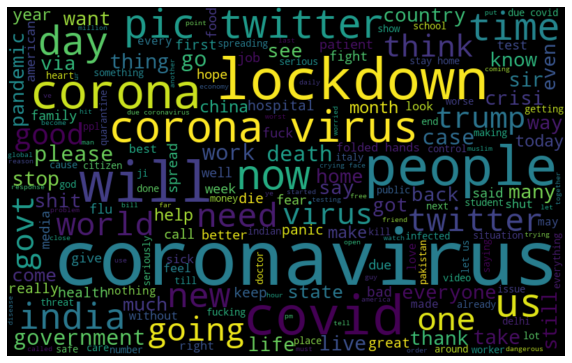

In [57]:
all_words = ' '.join([text for text in df_dataset['Tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [37]:
df_dataset.to_csv(r'/content/sentiments.txt', header=None, index=None, sep=' ', mode='a')


#Load FastText 

In [38]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip

--2022-01-07 22:23:30--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2 [following]
--2022-01-07 22:23:30--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [  <=>               ]   4.17M  9.93MB/s    in 0.4s    

2022-01-07 22:23:30 (9.93 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
  inflating: fa

In [39]:
%cd fastText-0.9.2



/content/fastText-0.9.2


In [40]:
!make

c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/vector.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/model.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/utils.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -

In [41]:
!pip install .

Processing /content/fastText-0.9.2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3125956 sha256=0cfa979cdf7c60fcbc623051770fcb55f0bafa65a86c9dd0b6febc633b51c96b
  Stored in directory: /root/.cache/pip/wheels/87/b3/c9/4ae793bec22dc8570ea6defb4ebb24d699f12b8c954db5f44f
Successfully built fasttext


In [42]:
import fasttext

#Train - Test Splitting

In [43]:
%cd ..


/content


In [44]:
!head sentiments.txt

"agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell their family that they are fine if covid case treated foc in hospitals" __label__sad
"if only i could have spent the with this cutie vc sakshi s i n g h coast crossing republik " __label__joy
"will nature conservation remain a priority in post corona bangladesh the daily star" __label__joy
"coronavirus disappearing in italy show this to intellectuals who say lockdowns do not work " __label__sad
"uk records lowest daily virus death toll since start of lockdown govt" __label__sad
"joe biden s coronavirus web address lands on a donation page for his campaign he is profiting from fear demopos" __label__fear
"respected sir in our telangana all private teachers and lecturers are in horrible situations due to covid and mainly private management chaithanya nd narayana b caz they told to all faculty 

In [45]:
!wc sentiments.txt

  3090  81051 479841 sentiments.txt


In [46]:
!head -n 2472 sentiments.txt > sentiment.train

In [47]:
!tail -n 618 sentiments.txt > sentiment.test

#Creating the model

In [48]:
model = fasttext.train_supervised(input="sentiment.train")

In [49]:
model.save_model("model_sentiment.bin")

In [50]:
model.predict("I am afraid of the virus infection")

(('__label__fear',), array([0.32111233]))

In [51]:
print("(Samples,\tPrecision,\tRecall)")
model.test("sentiment.test")

(Samples,	Precision,	Recall)


(618, 0.3802588996763754, 0.3802588996763754)

#Using Ngrams

In [52]:
model1 = fasttext.train_supervised(input="sentiment.train", lr=1.0, epoch=25, wordNgrams=2)

In [53]:
print("(Samples,\tPrecision,\tRecall)")
model1.test("sentiment.test")

(Samples,	Precision,	Recall)


(618, 0.6245954692556634, 0.6245954692556634)

In [56]:
model1.predict("feels great to get a  negative test result")

(('__label__joy',), array([0.99955285]))